In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (12, 8)

## Sensitivity to ETI RADAR

If we would like to determine the sensitivity to a ETI RADAR system we have to consider the intensity of, and distance to the ETI signal, and the sensitivity of our radio telescopes. We need to answer the following:

1. What is the flux density of a RADAR or any broadband, short duration in time pulse from a distance source, such as an ETI?
2. How sensitive would we be to such a signal with the current and future radio telescopes?

We will use the Arecibo RADAR system as a proxy for an ETI RADAR system. The Arecibo S-band (12.6 cm, 2380 MHz) RADAR system ([1](http://www.naic.edu/~nolan/radar/),[2](http://www.naic.edu/~astro/RXstatus/Sradar/Sradar.shtml)) is a highly-directive, long-distance signal marker. The RADAR system has the following specifications:

| S-Band RADAR  |               |
| -------------:| ------------- |
| Transmission Frequency | 2380 MHz |
| Bandwidth     | 100 MHz       |
| Polarization  | Dual Circular |
| Power         | 900 kW ([3](https://arxiv.org/pdf/1604.01080.pdf)) |
| Analogue Gain | 10 K/Jy ([4](http://www.naic.edu/~phil/pnt/pnterrs_sysperf_afterPainting_apr16.html),[5](http://www.naic.edu/~phil/pnt/sbnx102_160421.pdf)) |
| $T_{\textrm{sys}}$ | 25 K ([4](http://www.naic.edu/~phil/pnt/pnterrs_sysperf_afterPainting_apr16.html),[5](http://www.naic.edu/~phil/pnt/sbnx102_160421.pdf)) |

Using the Nyquist approximation for a thermal noise source ([6](https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise)), the power of the RADAR can be related to a temperature:

$$P_{\textrm{RADAR}} = k \cdot T_{\textrm{RADAR}} \cdot \Delta \nu$$

where $k$ is the Boltzman constant and $\Delta \nu$ is the transmission bandwidth.

In [2]:
pRadar = 9e5 # Watts (J/s)
bw = 100e6 # Hz (1/s)
kk = 1.38064852e-23 # Boltzman constant J/K
tRadar = pRadar / (kk * bw) # K

### Flux Density of the Arecibo RADAR

Making the approximation that the Arecibo telescope is a parabolic reflector we can use standard analytical models for gain and beam size. This is of course not correct as the Arecibo telescope is a Gregorian-offset, spheriodal dish, but this is a decent approximation. Using the angular resolution equation([6](https://en.wikipedia.org/wiki/Angular_resolution)), the beamwidth of a parabolic reflector can be approximated as

$$\Delta \theta_{\textrm{3 dB}} = 1.22 \frac{\lambda}{D} = 1.22 \frac{c}{\nu \cdot D}$$

The beamwidth is defined here as the 3 dB crossing point, or a beamwidth such that the power drops off by a factor of two, this is also called the *half-power beamwidth*. The diameter $D=305$ m is used, though though the effective diameter is smaller because the spheriodal primary dish is only partially illuminated. And, $\lambda$ is the transmission wavelength. The solid angle illuminated by the beam is

$$\Omega_{\textrm{Beam}} = \pi \left(\frac{\Delta \theta_{\textrm{3 dB}}}{2}\right)^2$$

In [3]:
cc = 299792458.0 # m/s
areciboDiameter = 305. # m
fCenter = 2380e6 # Hz
freqs = fCenter + np.array([-1. * bw/2., bw/2.]) # lowest and highest frequency
thetaHPBW = 70. * cc / (areciboDiameter * freqs) * (np.pi/180.)# radians
omegaBeam = np.pi * (thetaHPBW / 2.)**2. # steradians
avgOmegaBeam = np.mean(omegaBeam)

print 'theta_HPBW: %f arcmin'%(np.mean(thetaHPBW) * (180./np.pi) * 60.)
print 'Omega_beam: %.2e sr'%avgOmegaBeam

theta_HPBW: 1.735341 arcmin
Omega_beam: 2.00e-07 sr


The antenna gain of a parabolic dish (Eq. 17.8.16 [7](http://www.ece.rutgers.edu/~orfanidi/ewa/), [8](https://en.wikipedia.org/wiki/Parabolic_antenna#Gain)) is

$$G_{\textrm{parabolic}} = \frac{4 \pi A_{\textrm{eff}}}{\lambda^2} = \epsilon \left( \frac{\pi D}{\lambda} \right)^2$$

where $A_{\textrm{eff}} = A \cdot \epsilon$ is the effective area of the telescope aperture which is a product of the geometrical area $A$ and aperture efficiency $\epsilon$. For the S-band system $\epsilon \approx 0.75$ ([9](http://www.naic.edu/~phil/sysperf/sysperfcum.html#sbn), [10](http://www.naic.edu/~phil/sysperf/sbn/sbn_csme_Cur.pdf)). As we can see from the gain and beamwidth equations, as the diameter of the dish increase there is an increase in gain, and a reduction in beam size.

**Note**: this gain $G_{\textrm{parabolic}}$ is the gain of the telescope due to the aperture geometry and efficiency, this term is *unit-less*. Often, there is another 'gain' term in radio astronomy in units K/Jy. This is the gain in the electornic system, and refers to the conversion between the measured values and the astronomical flux.

In [4]:
effic = 0.75 # Arecibo dish efficiency at S-band
dd = 305. # m, Arecibo aperture size
obsWavelength = cc / fCenter
gainPara = effic * (((np.pi * dd)/obsWavelength)**2.)
print 'Antenna gain of Arecibo: %.3e'%gainPara

Antenna gain of Arecibo: 4.340e+07


We can compute an 'apparent' Luminosity assuming the RADAR is coming from an isotropic source, this is called the *effective isotropic radiated power*. We will use this to transform the highly-directional transmission into an isotropic luminosity, using this we will compute the flux density. We do this assuming that the RADAR transmitter is aligned at boresight with the receiving telescope.

$$L_{\textrm{RADAR, iso}, \nu} = \frac{G_{\textrm{parabolic}} \cdot P_{\textrm{RADAR}}}{\Delta \nu}$$

It is important to note that this is lumonisty is in units W / Hz, that is the power per unit frequency. The bandwidth of the transmitter will have a large effect on the distance to a detectable signal as we will see later.

In [5]:
lumIso = gainPara * pRadar / bw # isotropic luminsity, W/Hz
print 'Luminosity: %.3e W/Hz'%lumIso

Luminosity: 3.906e+05 W/Hz


The flux density of a source $S_{\nu}$ can be related to the isotropic luminsity as

$$S_{\nu} = \frac{L_{\textrm{iso}, \nu}}{4 \pi r^2}$$

where $r$ is the distance from the source to the detector. The flux density is in units $\textrm{W} \; \textrm{m}^{-2} \; \textrm{Hz}$ and can be converted to Janskys (Jy) with

$$1 \; \textrm{Jy} = 10^{-26} \; \frac{\textrm{W}}{\textrm{m}^2 \textrm{Hz}}$$

In [6]:
fluxDen = lambda r: lumIso / (4. * np.pi * r**2.)
fluxDenJy = lambda r: fluxDen(r) / 10e-26

ly2m = 9460730472580800. # number of meters in a light year
distMoonEarth = 384400000. # distance from Earth to Moon in meters
distJupiterEarth = 588e9 # distance from Earth to Jupiter in meters
distAlphaCentEarth = 4.367 * ly2m
print 'Flux density of the Arecibo RADAR from the Moon: %.3e Jy'%fluxDenJy(distMoonEarth)
print 'Flux density of the Arecibo RADAR from Jupiter: %.3e Jy'%fluxDenJy(distJupiterEarth)
print 'Flux density of the Arecibo RADAR from Alpha Centari (%.3f light-years): %.3e Jy'%\
    (4.367,fluxDenJy(distAlphaCentEarth))
print 'Flux density of the Arecibo RADAR at 1 parsec: %.3e mJy'%(1e3 * fluxDenJy(3.26 * ly2m))
print 'Flux density of the Arecibo RADAR at 10 parsec: %.3e uJy'%(1e6 * fluxDenJy(32.6 * ly2m))

Flux density of the Arecibo RADAR from the Moon: 2.103e+12 Jy
Flux density of the Arecibo RADAR from Jupiter: 8.990e+05 Jy
Flux density of the Arecibo RADAR from Alpha Centari (4.367 light-years): 1.821e-04 Jy
Flux density of the Arecibo RADAR at 1 parsec: 3.268e-01 mJy
Flux density of the Arecibo RADAR at 10 parsec: 3.268e+00 uJy


Looking at these numbers, a RADAR transmission needs to be fairly close to Earth to be detectable. We are in the micro-Jansky level at just 10 parsecs. To get a feel for how detectable an Arecibo RADAR signal is, let us compute the sensitivity of some radio telescopes to determine the maximum searchable distance.

---

### Telescope Sensitivity

The minimum sensitivity of a radio telescope $S_{\textrm{min}}$ is described by the *radiometer equation*, for the case of a RADAR source it has been slightly expanded

$$S_{\textrm{min}} = \textrm{SEFD} \frac{\textrm{SNR}_\textrm{min}}{N_{\textrm{antenna}} \; \sqrt{d_{\textrm{cycle}} \; N_{\textrm{pol}} \; \Delta \tau_{\textrm{obs}} \; \Delta \nu_{\textrm{obs}}}}$$

where $\textrm{SEFD}$ is the system-equivalent flux density of a telescope in an array of $N_{\textrm{antenna}}$ antennas with $N_{\textrm{pol}}$ polarizations, for a given integration time $\Delta \tau_{\textrm{obs}}$ and bandwidth $\Delta \nu_{\textrm{obs}}$. The last term $d_{\textrm{cycle}}$ is the duty cycle of the RADAR, for a continuous signal $D=1$, if the RADAR has a pulse width of 1 ms, every second then $d_{\textrm{cycle}} = \frac{1 \textrm{ms}}{1 \textrm{s}} = 0.001$. Note, we are assuming $\Delta \tau_{\textrm{obs}}$ is a longer time length then the RADAR repetition time scale.

Now assuming we know the duty cycle rate and bandwidth of the transmitting RADAR, how far away is a radio telescope sensitive to? Note, these assumptions are for the optimal detection case. Performing a large matched filter search over the time, duty cycle, and bandwidth space it is reasonable to make these assumptions.

For our test case we will use $d_{\textrm{cycle}}=1$, a minimum detection SNR of 7 and the Arecibo S-band RADAR specifications to look at the sensitivity of Arecibo, GBT, Parkes, MeerKAT, and the SKA. Note, we are assuming that an L-band RADAR would have similar specification for these telescopes.

Note, SEFD and telescope sensitivity is related to the *Friis transmission equation* which relates the power received by a telescope in relation to the distance and power transmitted by another antenna in idealized conditions ([7](http://www.montana.edu/jshaw/documents/RadiometryFriis%20Eqn%20-%20Shaw%20-%20AJP%202013.pdf)).

In [7]:
dutyCycle = 1. # duty cycle of RADAR
snrMin = 7. # minimum SNR needed for verifiable detection
nuObs = 100e6
minObsTime = np.log10(0.001)
maxObsTime = np.log10(60.*5.)
tObs = np.logspace(minObsTime, maxObsTime, num=1024) # observation integration time range
print tObs

def sMin(SEFD, snr, nAnt, nPol, dc, tObs, nuObs):
    """
    SEFD: float, system-equivalent flux density
    snr: float, minimum SNR needed for verifiable detection
    nAnt: int, number of antennas/elements in the telescope array
    nPol, int, number of polarizations in the reciever (1 or 2)
    dc: float, duty cycle of RADAR
    tObs: float, observational integration time, in seconds
    nuObs: float, observational bandwidth, in Hz
    """
    return SEFD * snr / (nAnt * np.sqrt(dc * nPol * tObs * nuObs))

[  1.00000000e-03   1.01240430e-03   1.02496246e-03 ...,   2.92693646e+02
   2.96324305e+02   3.00000000e+02]


#### Arecibo

Using the L-band system, the SEFD is approximately 3 Jy ([8](http://www.naic.edu/alfa/performance/)).

In [8]:
areciboSEFD = 3. # Jy
areciboSMin = sMin(areciboSEFD, snrMin, 1, 2., dutyCycle, tObs, nuObs)

#### GBT

Using the L-band system, the SEFD is approximately 10 Jy ([9](https://science.nrao.edu/facilities/gbt/proposing/GBTpg.pdf)).

In [9]:
gbtSEFD = 10. # Jy
gbtSMin = sMin(gbtSEFD, snrMin, 1, 2., dutyCycle, tObs, nuObs)

#### Parkes

Using the L-band system, using $T_{\textrm{sys}} = 25 \textrm{K}$ and gain $G = 1 / 1.2 \; \textrm{K/Jy}$, and $\textrm{SEFD} = T_{\textrm{sys}} / G$, then SEFD is approximately 30 Jy ([10](https://www.parkes.atnf.csiro.au/observing/documentation/user_guide/pks_ug_3.html)).

In [10]:
parkesSEFD = 25. * 1.2 # Jy
parkesSMin = sMin(parkesSEFD, snrMin, 1, 2., dutyCycle, tObs, nuObs)

#### MeerKAT

Using the L-band system, the SEFD is approximately 440 Jy ([11](http://public.ska.ac.za/meerkat/meerkat-schedule)).

In [11]:
meerkatSEFD = 440. # Jy
meerkatSMin = sMin(meerkatSEFD, snrMin, 64, 2., dutyCycle, tObs, nuObs)

#### SKA Phase 1

The SEFD of a dish element is approximately that of a MeerKAT dish. In Phase 1 250 dishes are planned ([12](https://www.skatelescope.org/uploaded/21705_130_Memo_Dewdney.pdf)).

In [12]:
ska1SEFD = 440. # Jy
ska1SMin = sMin(ska1SEFD, snrMin, 250, 2., dutyCycle, tObs, nuObs)

#### SKA Phase 2

In Phase 2 of the SKA the SEFD of a dish element not expected to chang, 2000 dishes are planned.

In [13]:
ska2SEFD = 440. # Jy
ska2SMin = sMin(ska2SEFD, snrMin, 2000, 2., dutyCycle, tObs, nuObs)

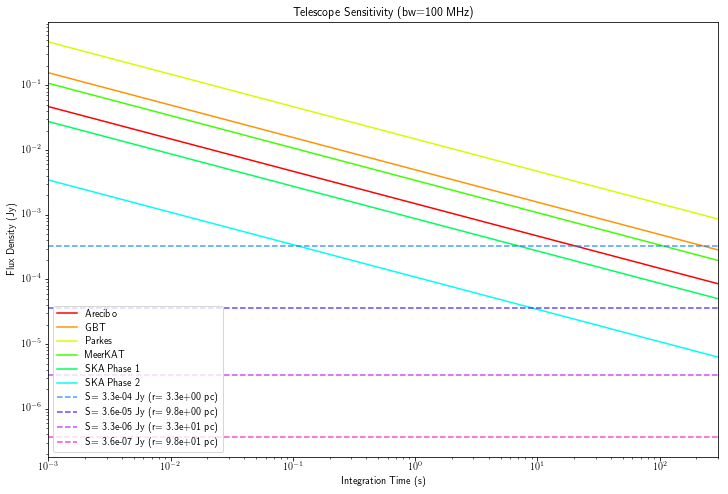

In [14]:
distParSec = 3.26 * np.array([1e0, 3e0, 1e1, 3e1]) # distances in parsecs

cmap = plt.cm.hsv
colors = iter(cmap(np.linspace(0, 0.9, 6 + len(distParSec)))) # number of telescopes + number of fluxs

plt.loglog(tObs, areciboSMin, color=next(colors), label='Arecibo')
plt.loglog(tObs, gbtSMin, color=next(colors), label='GBT')
plt.loglog(tObs, parkesSMin, color=next(colors), label='Parkes')
plt.loglog(tObs, meerkatSMin, color=next(colors), label='MeerKAT')
plt.loglog(tObs, ska1SMin, color=next(colors), label='SKA Phase 1')
plt.loglog(tObs, ska2SMin, color=next(colors), label='SKA Phase 2')

for dVal in distParSec:
    fd = fluxDenJy(dVal * ly2m)
    plt.axhline(y=fd, xmin=0.0, xmax=1.0, color=next(colors), linestyle="--", alpha=0.7, \
                label='S= %.1e Jy (r= %.1e pc)'%(fd, dVal))

plt.ylabel('Flux Density (Jy)')
plt.xlabel('Integration Time (s)')
plt.xlim(10**minObsTime, 10**maxObsTime)
plt.title('Telescope Sensitivity (bw=%.0f MHz)'%(bw/1e6))
plt.legend()

The plot above shows the sensitivty of various telescope (both single dish, and arrays) which can be used to detect RADAR signals as a function of integration time. Most of these telescopes can detect an Arecibo RADAR at a few light-years. SKA Phase 2 can detect out to 10's of light-years. But, overall this doesn't look great. Even at very optimistic integration times the distance is small. And, there are only a few stars in that small volume. So is there no chance?

There is. I have used the maximum observing bandwidth of 100 MHz and constant signal (i.e. duty cycle = 1) to generate this plot. Now in our idealistic Arecibo RADAR we can't improve the duty cycle, but can work with the bandwidth. The nearly megawatt of power is evenly distributed across 100 MHz of bandwidth. If instead the power was concentrated to a smaller bandwidth, say 1 MHz we get a significant improvement. Ths important point here about sensitivity is that the transmitter distributes the power across the bandwidth linearly, but the observing bandwidth $\Delta \nu_{\textrm{obs}}$ in the radiometer equation only improves the sensitivity by a square root of the bandwidth. This is because the radiometer equation assumes the signal is weak compared to the system noise of the reciever. This is true, the transmitted RADAR signal starts strong, but by the time it reaches the reciever, it is weak compared to the system noise. When adding up the power across the band there is a weak signal, but also a noise term being summed. A better RADAR system in this case would have a very narrow transmission bandwidth.

As for the duty cycle, it can be thought of as virtual. Assuming a RADAR signal goes on indefinately, even with a low duty cycle, sufficent $\Delta \tau_{\textrm{obs}}$ can be accumulated using a folding or gating search. This requires recording high time resolution spectra, and given enough computational power, a search can be preformed similar to pulsar searches.

If we decrease the transmission bandwidth, holding all else equal we can improve the detectable RADAR distance.

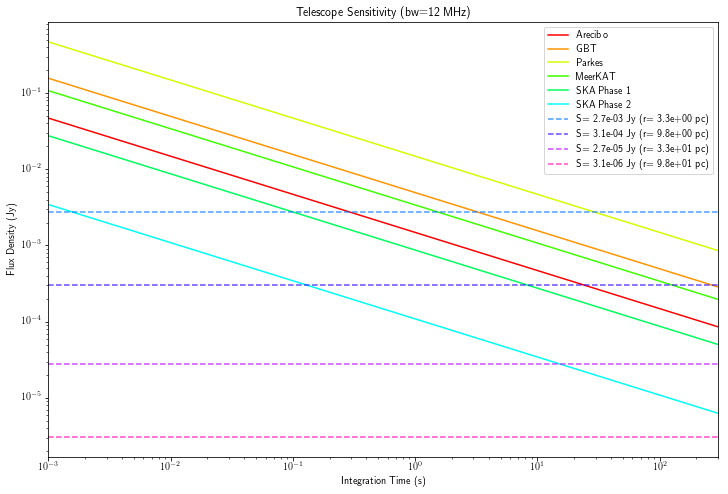

In [15]:
bw = 0.005 * fCenter # 0.5% of the central frequency, Hz (1/s)
lumIso = gainPara * pRadar / bw # isotropic luminsity, W/Hz

distParSec = 3.26 * np.array([1e0, 3e0, 1e1, 3e1]) # distances in parsecs

cmap = plt.cm.hsv
colors = iter(cmap(np.linspace(0, 0.9, 6 + len(distParSec)))) # number of telescopes + number of fluxs

plt.loglog(tObs, areciboSMin, color=next(colors), label='Arecibo')
plt.loglog(tObs, gbtSMin, color=next(colors), label='GBT')
plt.loglog(tObs, parkesSMin, color=next(colors), label='Parkes')
plt.loglog(tObs, meerkatSMin, color=next(colors), label='MeerKAT')
plt.loglog(tObs, ska1SMin, color=next(colors), label='SKA Phase 1')
plt.loglog(tObs, ska2SMin, color=next(colors), label='SKA Phase 2')

for dVal in distParSec:
    fd = fluxDenJy(dVal * ly2m)
    plt.axhline(y=fd, xmin=0.0, xmax=1.0, color=next(colors), linestyle="--", alpha=0.7, \
                label='S= %.1e Jy (r= %.1e pc)'%(fd, dVal))

plt.ylabel('Flux Density (Jy)')
plt.xlabel('Integration Time (s)')
plt.xlim(10**minObsTime, 10**maxObsTime)
plt.title('Telescope Sensitivity (bw=%.0f MHz)'%(bw/1e6))
plt.legend()

It is reasonable for a Klystron, such as that used in the Arecibo RADAR, to cover a bandwidth that is a few precent of the central transmission frequency, and other transmitters can cover a range of fractional bandwidths ([13](https://en.wikipedia.org/wiki/Klystron), [14](http://www.radartutorial.eu/08.transmitters/Radar%20Transmitter.en.html)). Powers of 10's of MW is reasonable for a high power RADAR transmitter ([15](https://www.eiscat.se/scientist/document/technical-specifications/)), but it should be noted that increasing the power of a Klystron also increases the bandwidth ([16](https://books.google.co.za/books/about/Radar_Handbook_Third_Edition.html?id=76uF2Xebm-gC)).

Now, let us consider the current Breakthrough Listen observation strategy. A typical observation is 5 minutes of a target source (Source A), 5 minutes on a nearby secondary source (Source B1), back to Source A, then to a new secondary source (Source B2), back to Source a, and then finally to a third secondary source (Source B3). This strategy is used to mitigate human-made RFI.

Assuming an ideal case where Source A has a Arecibo-like RADAR, with a duty cycle $d_{\textrm{cycle}} = 1$, pointed directly at Earth, what is the maximum distance this source can be for a given telescope? That is, where is

$$S_{\textrm{min}} = S_{\nu}(r_{\textrm{max}})$$

Solving for $r_{\textrm{max}}$

$$r_{\textrm{max}} = \left( \frac{L_{\textrm{iso}, \nu} \cdot N_{\textrm{antenna}} \; \sqrt{d_{\textrm{cycle}} \; N_{\textrm{pol}} \; \Delta \tau_{\textrm{obs}} \; \Delta \nu_{\textrm{obs}}}}{4 \pi \cdot \textrm{SEFD} \cdot \textrm{SNR}_\textrm{min}} \right)^{1/2}$$

In [16]:
maxtObs = 15. * 60. # maximum BL observation time on a target source, seconds
rMax = lambda SEFD, nAnt, nPol: np.sqrt(((lumIso/10e-26) * nAnt * np.sqrt(dutyCycle * 2. * maxtObs * nuObs))/ \
                                 (4. * np.pi * SEFD * snrMin)) # meters

print 'Maximum detectable distance of a narrow-band Arecibo RADAR, (t=%.1f s)'%(maxtObs) 
print '\tArecibo: %.1e ly'%(rMax(areciboSEFD, 1, 2) / ly2m)
print '\tGBT: %.1e ly'%(rMax(gbtSEFD, 1, 2) / ly2m)
print '\tParkes: %.1e ly'%(rMax(parkesSEFD, 1, 2) / ly2m)
print '\tMeerKAT: %.1e ly'%(rMax(meerkatSEFD, 64, 2) / ly2m)
print '\tSKA-1: %.1e ly'%(rMax(ska1SEFD, 250, 2) / ly2m)
print '\tSKA-2: %.1e ly'%(rMax(ska2SEFD, 2000, 2) / ly2m)

Maximum detectable distance of a narrow-band Arecibo RADAR, (t=900.0 s)
	Arecibo: 2.4e+01 ly
	GBT: 1.3e+01 ly
	Parkes: 7.7e+00 ly
	MeerKAT: 1.6e+01 ly
	SKA-1: 3.2e+01 ly
	SKA-2: 9.0e+01 ly


Looked at another way, we can ask, given a distance how powerful must a transmitter be to be detected by a radio telescope on Earth? Solving for $P_{\textrm{RADAR}}$ as a function of distance and minimum telescope sensitivity:

$$P_{\textrm{RADAR, min}} = \frac{L_{\textrm{RADAR, iso}, \nu} \cdot \Delta \nu}{G_{\textrm{parabolic}}}
= \frac{4 \pi r_{\textrm{max}}^2 \cdot S_{\textrm{min}} \cdot \Delta \nu}{G_{\textrm{parabolic}}}$$

**How reasonable are these detectable distances?**

I have made a number of optimistic assumptions:

* ETI would be beaming a signal directly at Earth, and we would be observing the point n the ky the signal is coming from (within the size of the telescope PSF main lobe).
* We would integrate for the full period of the observation, and not be contaminated by terrestrial RFI
* The duty cycle of the transmission RADAR is unity.
* We would have sufficient search pipelines to search over all bandwidth such that the receiving bandwidth is equal to the transmission bandwidth.
* A minimal signal to noise of 10 is reasonable for a detection.
* The transmission signal would concentrate enough power in a narrow band.

But, I have also left room for optimism:

* ETI could be using a stronger RADAR, with an even narrower band.
* We could pick a lower minimum signal to noise threshold.
* The sidelobes of the telescope have reasonable sensitivity also.
* Future arrays will potentially be more sensitive due to improvements in the system noise.

I think we are not over-optimistically modelling an ETI RADAR, and could reasonably detect such a signal in a local region around Earth.

The local stellar density is measured to be approximately 0.15 stars per cubic parsec ([17](http://adsabs.harvard.edu/abs/1978SvA....22..186L)). Using this density we can work out the number of systems we could be sensitive too.

In [17]:
# Simple model of the Milky Way with uniform density
rhoStars = 0.15 # stars / pc^3

Based on the maximum distance a telescope is sensitive to, the number of searchable stars is:

In [18]:
print 'Maximum number of stars sensitive to:'
vMaxArecibo = (4. * np.pi / 3.) * ((rMax(areciboSEFD, 1, 2) / ly2m)**3.)
print '\tArecibo: %i stars'%(vMaxArecibo * rhoStars)

vMaxGBT = (4. * np.pi / 3.) * ((rMax(gbtSEFD, 1, 2) / ly2m)**3.)
print '\tGBT: %i stars'%(vMaxGBT * rhoStars)

vMaxParkes = (4. * np.pi / 3.) * ((rMax(parkesSEFD, 1, 2) / ly2m)**3.)
print '\tParkes: %i stars'%(vMaxParkes * rhoStars)

vMaxMeerKAT = (4. * np.pi / 3.) * ((rMax(meerkatSEFD, 64, 2) / ly2m)**3.)
print '\tMeerKAT: %i stars'%(vMaxMeerKAT * rhoStars)

vMaxSKA1 = (4. * np.pi / 3.) * ((rMax(ska1SEFD, 250, 2) / ly2m)**3.)
print '\tSKA-1: %i stars'%(vMaxSKA1 * rhoStars)

vMaxSKA2 = (4. * np.pi / 3.) * ((rMax(ska2SEFD, 2000, 2) / ly2m)**3.)
print '\tSKA-2: %i stars'%(vMaxSKA2 * rhoStars)

Maximum number of stars sensitive to:
	Arecibo: 8994 stars
	GBT: 1477 stars
	Parkes: 284 stars
	MeerKAT: 2592 stars
	SKA-1: 20016 stars
	SKA-2: 452915 stars
